# Topic Modeling with Eugenics Articles

## Import Data

Get data from picklefiles and store in DataFrame

In [1]:
import pickle
import pandas as pd 
import os

dicts = []
folders = ['equarterly_clean_articles/', 'ereview_clean_articles/', 'socbio_clean_articles/']
for folder in folders:
    filenames = os.listdir(folder)
    for file in filenames:
        infile = open(folder + file,'rb')
        corp_dict = pickle.load(infile)
        dicts.append(corp_dict)
        infile.close
    
df = pd.DataFrame(dicts)

df['title'] = df['title'].str.lower()
df['content'] = df['content'].str.lower()
df['year'] = pd.to_numeric(df['year'])
df.columns

Index(['title', 'year', 'publisher', 'content', 'has_ref', 'references',
       'start_page', 'end_num'],
      dtype='object')

## ***Tokenize with NLTK and Spacey***
### In general, there are two levels of tokenization: sentence level and word level.

In [2]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zeke/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    tok = []
    tokens = parser(text)
    for token in tokens:
        if not token.orth_.isalpha() :
            continue
        if len(token) < 3:
            continue
        else:
            tok.append(token.lower_)
    return tok

In [4]:
from nltk.tokenize import sent_tokenize

In [5]:
import random

random.seed(42)

df["token"] = df['content'].apply(sent_tokenize)

def word_tok(sentances):
    new_sents = []
    for sent in sentances:
        test = random.random()
        if test > 0.8:
            new_sents.append(tokenize(sent))
    
    return new_sents

df["token"] = df['token'].apply(word_tok)

df['token']


0       [[medical, genetics, described, discipline, wh...
1       [[may, approaching, the, problem, measuring, t...
2       [[invited, participants, represented, medical,...
3       [[editor, note, generally, agreed, that, much,...
4       [[figure], [areas, investigated, and, sample, ...
                              ...                        
2404    [[the, prevalence, operative, menopause, was, ...
2405    [[nevertheless, complex, characters, that, now...
2406    [[the, results, suggest, that, the, present, a...
2407    [[mangold, and, powell, griner, genetic, compo...
2408    [[whiting, martin, brewis, underwood], [should...
Name: token, Length: 2409, dtype: object

# ***Stemming with NLTK***

#### The concept of stemming is a standardized method. Except for tense, many variations of words have the same meaning. To understand stem technique, consider the following:

- #### ***I like writing python code in a pythonic way.***
- #### ***I like pythoning pythonic python code.***

#### As you may see, although the two sentence vary in terms of using ***python***, however, the stem of the two sentences is the same: **python**

In [6]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [7]:
# def stem_list(sentances):
#     new_sents = []
#     for sent in sentances:
#         new_words = []
#         for word in sent:
#             new_words.append(ps.stem(word))

#         new_sents.append(new_words)

#     return new_sents

# df['token'] = df['token'].apply(stem_list)

# df['token']

# ***Lemmatizing with NLTK***

#### An operation very similar to stemming is called lemmatizing. The main difference between the two is that, stemming can create non-existent vocabulary.Let's look at some examples.

In [8]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lem_list(sentances):
    new_sents = []
    for sent in sentances:
        new_words = []
        for word in sent:
            new_words.append(lemmatizer.lemmatize(word))
    
        new_sents.append(new_words)
    
    return new_sents

df['token'] = df['token'].apply(lem_list)

[nltk_data] Downloading package wordnet to /Users/zeke/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# ***Stop words removal with NLTK***

#### The process of converting data into something the computer can understand is called pre-processing. One of the main forms of preprocessing is to filter out *useless* data. In NLP, the useless words (data) are called **stop words**.

#### The key assumption behinds this is: ***Some words are more meaningful than others***.

In [9]:
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/zeke/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop(tokens):
    stop_words = set(stopwords.words('english'))
    stop_words.add('eee')
    stop_words.add('cece')
    new_tokens = []
    for sentance in tokens:
        new_tokens.append([w for w in sentance if not w in stop_words])
        
    return new_tokens

df['token'] = df['token'].apply(remove_stop)

df['token']

0       [[medical, genetics, described, discipline, pr...
1       [[may, approaching, problem, measuring, wrong,...
2       [[invited, participant, represented, medical, ...
3       [[editor, note, generally, agreed, much, resea...
4       [[figure], [area, investigated, sample, size, ...
                              ...                        
2404    [[prevalence, operative, menopause, wa, slight...
2405    [[nevertheless, complex, character, appear, un...
2406    [[result, suggest, present, approach, yield, p...
2407    [[mangold, powell, griner, genetic, component,...
2408    [[whiting, martin, brewis, underwood], [like, ...
Name: token, Length: 2409, dtype: object

# **Topic Modeling With LDA**

In [12]:
from gensim import corpora
import gensim
import pyLDAvis.gensim

def get_tokens(df):
    for index, row in df.iterrows():
        for token in row['token']:
            yield token
            
def topic_model(df, num_topics):
    text_data = list(get_tokens(df))
    dictionary = corpora.Dictionary(text_data)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
    lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
    
    return ldamodel, lda_display


model, display = topic_model(df, 25)

# model = []
# display = []
# for i in range(1910, 2000, 10):
#     new_model, new_display = topic_model(df[(df['year'] > i) & (df['year'] < i+10 )], 6)
#     model.append(new_model)
#     display.append(new_display)
    
# pyLDAvis.display(display[1])

In [40]:
# def get_tokens(df):
#     for index, row in df.iterrows():
#         for token in row['token']:
#             yield token

# num_topics = 25
# text_data = list(get_tokens(df))
# dictionary = corpora.Dictionary(text_data)
# corpus = [dictionary.doc2bow(text) for text in text_data]

# ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = num_topics, id2word=dictionary, passes=15)
# lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)

other_texts = list(get_tokens(df[(df['year'] > 1910) & (df['year'] < 1950 )]))
other_corpus = [dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus
vector = model[unseen_doc]

/Users/zeke/Desktop/ECS189L/TopicModelingProject/venv/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/Users/zeke/Desktop/ECS189L/TopicModelingProject/venv/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1625: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)
/Users/zeke/Desktop/ECS189L/TopicModelingProject/venv/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:1231: VisibleDeprecationWarning: Creating an ndar

<AxesSubplot:>

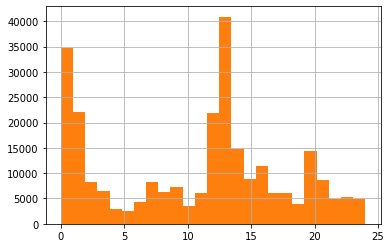

In [92]:
def get_best_topic(vector):
    df = pd.DataFrame(vector, columns=["Topic", "Prob"])
    return df[df["Prob"] == df["Prob"].max()]["Topic"].values[0]

other_texts = list(get_tokens(df[(df['year'] > 1910) & (df['year'] < 1950 )]))
other_corpus = [dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus
preWW2 = model[unseen_doc]

other_texts = list(get_tokens(df[(df['year'] >= 1950)]))
other_corpus = [dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus
postWW2 = model[unseen_doc]


prob_df = pd.Series(preWW2)
df1 = pd.DataFrame()
df1["topic"] = prob_df.apply(get_best_topic)
df1["topic"].hist(bins = 25)

prob_df = pd.Series(postWW2)
df2 = pd.DataFrame()
df2["topic"] = prob_df.apply(get_best_topic)
df2["topic"].hist(bins = 25)

<AxesSubplot:>

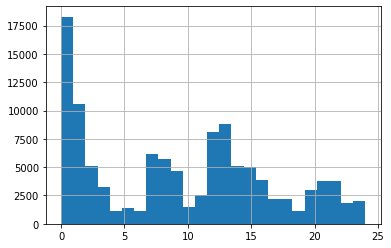

In [97]:
df1["topic"].hist(bins = 25)

<AxesSubplot:>

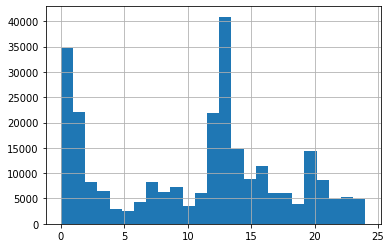

In [96]:
df2["topic"].hist(bins = 25)

In [91]:
import pickle 
import pandas as pd
import pyLDAvis.gensim
from gensim import corpora
import gensim

# Save Topic Models and Visualizations and DF

# with open('topic_models.pkl', 'wb') as f:
#     pickle.dump(model, f)
    
# with open('topic_models_vis.pkl', 'wb') as f:
#     pickle.dump(display, f)
    
# with open('DataFrame.pkl', 'wb') as f:
#     pickle.dump(df, f)
    
    
# Load Topic Models and Visualizations and DF
# with open('topic_models.pkl', 'rb') as f:
#     model = pickle.load(f)
    
# with open('topic_models_vis.pkl', 'rb') as f:
#     display = pickle.load(f)
    
with open('DataFrame.pkl', 'rb') as f:
    df = pickle.load(f)
    
    

## Word Cloud Visualization

In [26]:
pyLDAvis.display(lda_display)

In [15]:
# from wordcloud import WordCloud
# from collections import Counter
# import matplotlib.pyplot as plt

# def get_tokens(df):
#     for index, row in df.iterrows():
#         for token in row['token']:
#             yield token
            
# def get_words(df):
#     for token in get_tokens(df):
#         for word in token:
#             yield word
            
# print("word cloud for decades by LDA topic importance: ")
# for i in range(9):
#     print("Decade: {}s".format(i*10 + 1910))
#     topics = model[i].print_topics(num_words=50)
#     topics = topics[0][1].split('+')

#     topic_dict = {}
#     for topic in topics:
#         word = topic.split('*')
#         freq = float(word[0].strip())
#         word = word[1].strip().strip('"')
#         if word not in topic_dict.keys():
#             topic_dict[word] = int(freq * 1000)
#         else:
#             topic_dict[word] += int(freq *1000)

#     text = " ".join([(k + " ")*v for k,v in topic_dict.items()])

#     text = text.replace("  ", " ")

#     wordcloud = WordCloud(collocations = False).generate(text)

#     _ = plt.imshow(wordcloud, interpolation='bilinear')
#     _ = plt.axis("off")
#     _ = plt.show()
    
    
# # print("word cloud for decades by pure word frequency: ")
# # for i in range(1910, 2000, 10):
# #     print("Decade: {}s".format(i))
# #     text = " ".join(get_words(df[(df['year']>=i) & (df['year']<i+10)]))
# #     wordcloud = WordCloud().generate(text)

# #     _ = plt.imshow(wordcloud, interpolation='bilinear')
# #     _ = plt.axis("off")
# #     _ = plt.show()

